In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.strikes.strikes import Loader, StrikeAnalyzer
from analysis.predictors.trajectories import TrajClassifier, TRAJ_DIR
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.direction"] = 'out'

In [57]:
ANIMALS = ['PV91', 'PV163', 'PV95', 'PV99']
MOVEMENTS_TYPES = ['random_low_horizontal', 'circle']
orm = ORM()

def load_trajs_dataset():
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(
            Trial, Trial.id == Strike.trial_id).join(
            Block, Block.id == Strike.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4']),
                Experiment.animal_id.in_(ANIMALS),
                Experiment.start_time > '2023-04-18',
                Block.movement_type.in_(MOVEMENTS_TYPES)
          ).all()
        
    strk_df_ = []
    trajs_ = {}
    for strk, tr, blk, exp in orm_res:
        if tr.bug_trajectory is None:
           continue
        
        try:
            strike_id = int(strk.id)
            ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=True, sec_before=3, sec_after=3)
            pose_df = ld.frames_df.copy()
            pose_df['total_sec'] = (pose_df[('time', '')] - pose_df.loc[ld.strike_frame_id, ('time', '')]).dt.total_seconds()
            pose_df = pd.concat([pose_df['time'], pose_df['total_sec'], pose_df['nose'][['x', 'y', 'prob']], pose_df['angle']], axis=1)
            pose_df['strike_id'] = strike_id
            trajs_[strike_id] = pose_df
            
            strk_df_.append({'id': strike_id, 'animal_id': exp.animal_id, 'block_id': blk.id, 'trial_id': tr.id, 'movement_type': blk.movement_type,
                             'time': strk.time, 'block_speed': blk.bug_speed, 'calc_speed': strk.calc_speed, 'is_hit': strk.is_hit, 'bug_type': strk.bug_type})
        except Exception as exc:
            print(f'Error in strike id: {strike_id}; {exc}')
            continue
      
    strk_df_ = pd.DataFrame(strk_df_).set_index('id')
    # add the frame_strike_id column to indicate which strike_id corresponds to each frame
    for strike_id, tf in trajs_.items():
        tf['frame_strike_id'] = None
        trial_id = strk_df_.loc[strike_id, 'trial_id']
        for strike_id_, row in strk_df_.query(f'trial_id=={trial_id}').iterrows():
            if tf.time.iloc[0] <= row.time <= tf.time.iloc[-1]:
                i = (tf.time - row.time).dt.total_seconds().abs().idxmin()
                tf.loc[i, 'frame_strike_id'] = strike_id_
    
    return strk_df_, trajs_


strk_df, trajs = load_trajs_dataset()

Error in strike id: 2583; Video prediction was not found for video db id: 2573
Error in strike id: 2584; Video prediction was not found for video db id: 2573
Error in strike id: 2585; Video prediction was not found for video db id: 2573
Error in strike id: 2586; Video prediction was not found for video db id: 2573
Error in strike id: 2587; Video prediction was not found for video db id: 2573
Error in strike id: 2582; Video prediction was not found for video db id: 2573
Error in strike id: 2624; Video prediction was not found for video db id: 2602
Error in strike id: 2625; Video prediction was not found for video db id: 2602
Error in strike id: 2627; Video prediction was not found for video db id: 2602
Error in strike id: 2626; Video prediction was not found for video db id: 2602
Error in strike id: 2630; Video prediction was not found for video db id: 2619
Error in strike id: 2631; Video prediction was not found for video db id: 2619
Error in strike id: 2581; Video prediction was not f

In [58]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'wb') as f:
    pickle.dump({'strk_df': strk_df, 'trajs': trajs}, f)

Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}
Start train for model traj_classifier_PV95_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV95_random_low_horizontal/20240711_142648
Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}


  0%|          | 0/123 [00:00<?, ?it/s]

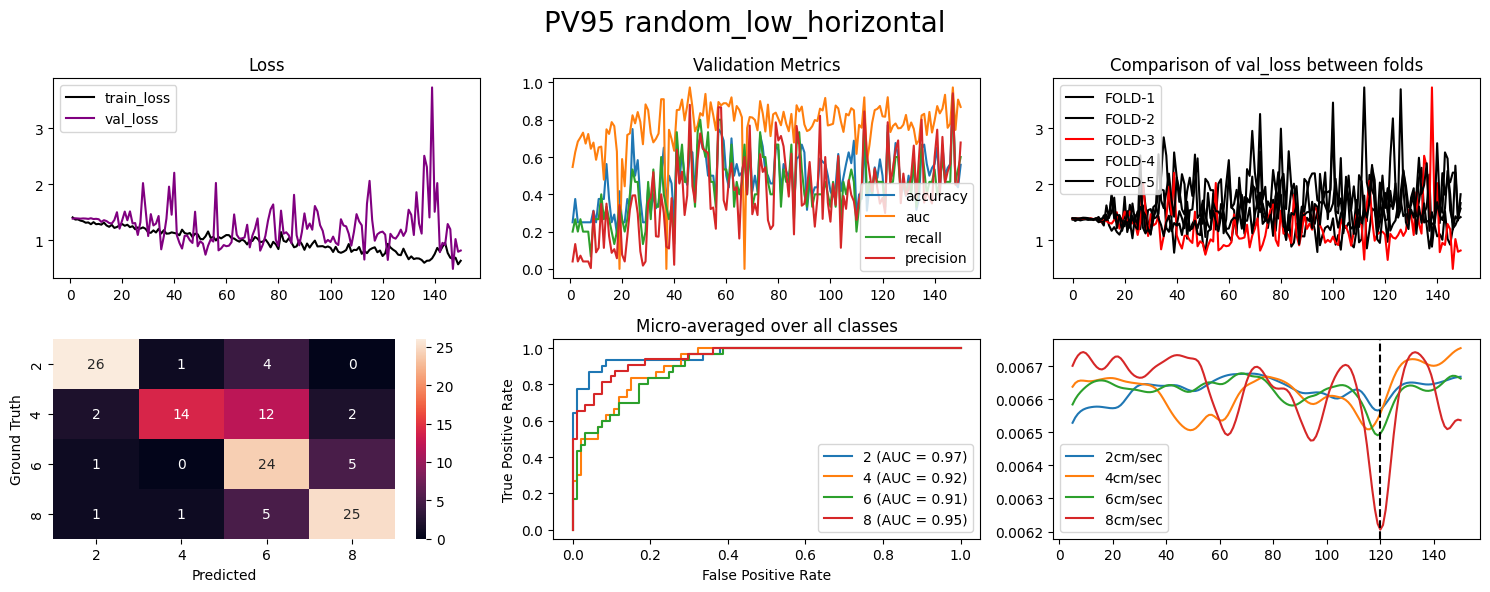

In [56]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='PV95', movement_type='random_low_horizontal', is_hit=False)
tj.train(is_plot=True);

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_180702


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_181135


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_181601


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_182022


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_182435


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_182846


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_183245


  0%|          | 0/127 [00:00<?, ?it/s]

Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240710_183644


  0%|          | 0/127 [00:00<?, ?it/s]

<AxesSubplot:xlabel='sub_section'>

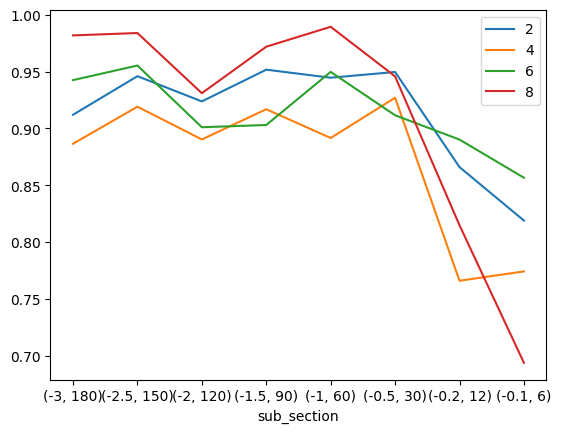

In [29]:
res = []
for sub_sect in [(-3, 180), (-2.5, 150), (-2, 120), (-1.5, 90), (-1, 60), (-0.5, 30), (-0.2, 12), (-0.1, 6)]:
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=sub_sect, is_resample=False,
                            animal_id='PV91', movement_type='random_low_horizontal', is_single_strike=False)
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['sub_section'] = sub_sect
        res.append(d)
    except Exception as exc:
        print(f'{sub_sect}: {exc}')

res = pd.DataFrame(res).set_index('sub_section')
res.plot()

In [60]:
np.arange(-3, 2.5, 0.5)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_103801
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_104015
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_104229
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_104443
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_104658
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_104912
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_105127
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_105342
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_105557
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_105811
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_110026
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_110240
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_110455
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_110709
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_110924
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_111139
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_111354
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_111608
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_111823
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_112038
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_112253
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240712_112506
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


  0%|          | 0/127 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_112610
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_112714
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_112818
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_112922
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113026
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113129
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113232
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113335
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113438
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113541
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113644
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113748
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113851
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_113954
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114058
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114201
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114304
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114408
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114511
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114615
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114718
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240712_114820
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

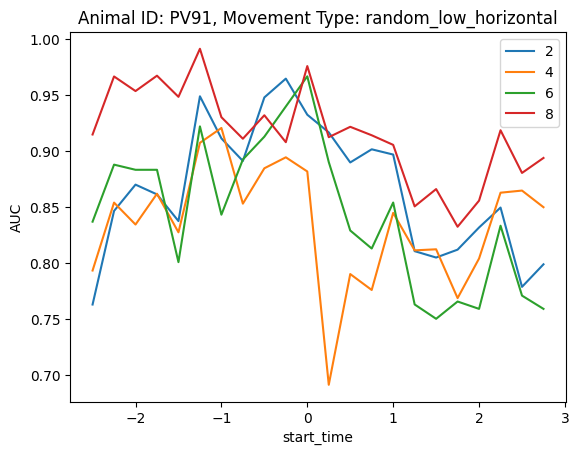

<Figure size 640x480 with 0 Axes>

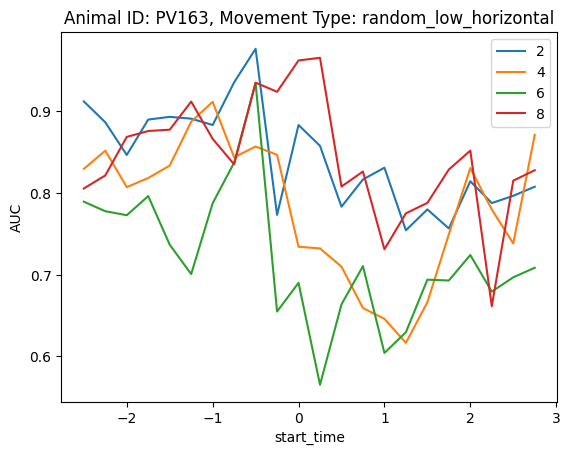

In [67]:
movement_type = 'random_low_horizontal'
for animal_id in ['PV91', 'PV163']:
    res = []
    for start_time in np.arange(-3, 2.5, 0.25):
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(start_time, 60), is_resample=False,
                                animal_id=animal_id, movement_type=movement_type, is_hit=False)
            tj.train(is_plot=False)
            d = tj.calc_auc()
            d['start_time'] = start_time + 0.5
            res.append(d)
        except Exception as exc:
            print(f'{exc}')

    res = pd.DataFrame(res).set_index('start_time')
    plt.figure()
    res.plot()
    plt.title(f'Animal ID: {animal_id}, Movement Type: {movement_type}')
    plt.ylabel('AUC')

In [33]:
res.mean(axis=1).idxmax()

(-2.5, 150)

In [66]:
res = {}
for strike_id, row in strk_df.iterrows():
    res.setdefault(row.animal_id, 0)
    if len(trajs[strike_id].frame_strike_id.value_counts()) == 1:
        res[row.animal_id] += 1

for animal_id, c in res.items():
    total = len(strk_df.query(f'animal_id=="{animal_id}"'))
    print(f'{animal_id}: {c}/{total}')

PV91: 184/369
PV99: 153/202
PV163: 122/186


In [10]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

<AxesSubplot:xlabel='t0'>

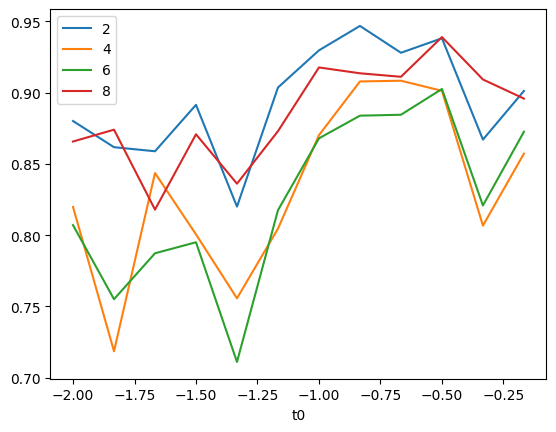

In [20]:
pd.DataFrame(res).set_index('t0').plot()

In [11]:
trajs[103]

,time,total_sec,x,y,prob,angle,strike_id,frame_strike_id
1876,2023-05-13 17:30:58.430510080,-2.999953,86.673642,59.457081,0.000014,2.378555,103,None
1877,2023-05-13 17:30:58.447176960,-2.983286,86.661825,59.449744,0.000014,2.382324,103,None
1878,2023-05-13 17:30:58.463843072,-2.966620,86.668932,59.451321,0.000015,2.376944,103,None
1879,2023-05-13 17:30:58.480508928,-2.949954,86.671703,59.451836,0.000014,2.378139,103,None
1880,2023-05-13 17:30:58.497175808,-2.933287,86.662005,59.448859,0.000014,2.381802,103,None
...,...,...,...,...,...,...,...,...
2172,2023-05-13 17:31:03.363766016,1.933303,38.375601,-2.057227,0.999967,1.593862,103,None
2173,2023-05-13 17:31:03.380433152,1.949970,38.420876,-1.589263,0.999987,1.598387,103,None
2174,2023-05-13 17:31:03.397099008,1.966636,38.439968,-1.247421,0.999963,1.603667,103,None
2175,2023-05-13 17:31:03.413764864,1.983302,38.397328,-0.991973,0.999987,1.611177,103,None


In [16]:
row = strk_df.iloc[0]
row.time

Timestamp('2023-05-16 18:34:46.391000')

In [27]:
res2 = []
for t0 in (np.arange(-5, 60, 10) / 60):
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t0, 60),
                        animal_id='PV91', movement_type='random_low_horizontal')
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['t0'] = t0
        res2.append(d)
    except Exception as exc:
        print(f'Error in t0: {t0}; {exc}')
        continue
    
res2 = pd.DataFrame(res2)
res2

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_123800
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_125040
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_130324
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_131607
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_132844
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_134121
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

Resampling trajectories to 141 samples from each block_speed class
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240709_135407
Resampling trajectories to 141 samples from each block_speed class


  0%|          | 0/564 [00:00<?, ?it/s]

,2,4,6,8,t0
0,0.891387,0.830894,0.831564,0.879382,-0.083333
1,0.892980,0.838405,0.841222,0.892125,0.083333
2,0.824120,0.765572,0.791442,0.836477,0.250000
3,0.821136,0.783864,0.747129,0.820834,0.416667
4,0.733665,0.738293,0.744714,0.796556,0.583333
5,0.781483,0.758094,0.755311,0.838908,0.750000
6,0.764482,0.743943,0.760609,0.819308,0.916667


<AxesSubplot:xlabel='t0'>

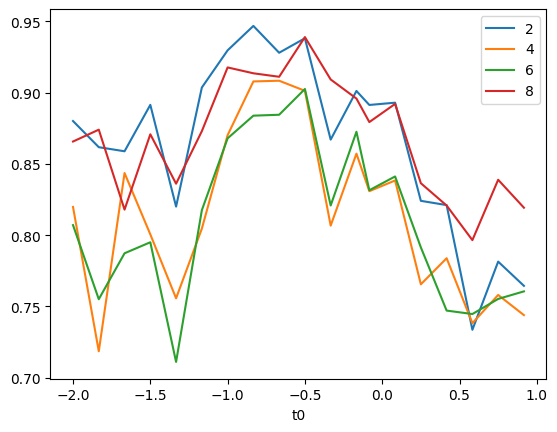

In [32]:
pd.concat([pd.DataFrame(res), res2]).set_index('t0').sort_index().plot()